In [1]:
from typing import *
import os
from copy import deepcopy
from pathlib import Path
from datetime import datetime, date, timedelta
from collections import defaultdict
import pickle
import gc
import warnings

import numpy as np
import pandas as pd
import pandas_profiling as pdp
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from nptyping import NDArray, Shape, Int, Float
from rich import print as rprint
import japanize_matplotlib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
import lightgbm as lgb
import optuna
import shap


sns.set(font='Hiragino Sans', style='whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義
DATA_DIR = Path()/'data'
DF_DIR = DATA_DIR/'dataframes'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

warnings.filterwarnings('ignore')

def save_pkl(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pkl(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


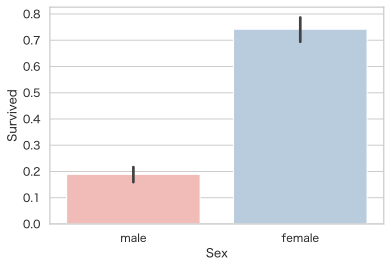

In [24]:
# データセットの読み込み
df_train = pd.read_csv(DATA_DIR/'train.csv')
df_test = pd.read_csv(DATA_DIR/'test.csv')

# train_dataとtest_dataの連結
df_test['Survived'] = np.nan
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)

# dfの情報
df.info()

# Sexと生存率の関係 
sns.barplot(x='Sex', y='Survived', data=df, palette='Pastel1')
plt.show()

df.to_pickle(DF_DIR/'all.pkl')

## 年齢の欠損補完

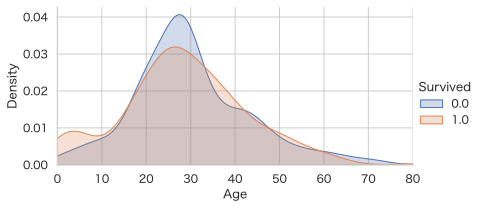

In [17]:
import lightgbm as lgb

df = pd.read_pickle(DF_DIR/'all.pkl')

# 推定に使用する項目を指定
df_age = df[['Age', 'Pclass', 'Sex', 'Parch', 'SibSp']]

# ラベル特徴量をワンホットエンコーディング
df_age = pd.get_dummies(df_age)

# 学習データとテストデータに分離し、numpyに変換
known_age = df_age[df_age.Age.notnull()].values  
unknown_age = df_age[df_age.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = lgb.LGBMRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

df.to_pickle(DF_DIR/'all_age_comp.pkl')

## 名前から特徴量を作成

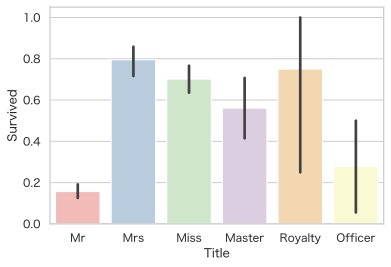

家族で16才以下または女性の生存率


1.000000    113
0.000000     32
0.750000      2
0.500000      1
0.333333      1
0.142857      1
Name: Survived, dtype: int64

家族で16才超えかつ男性の生存率


0.000000    116
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64

Dead_list =  {'Jussila', 'Panula', 'Zabour', 'Lahtinen', 'Boulos', 'Barbara', 'Elias', 'Skoog', 'Johnston', 'Attalah', 'Olsson', 'Canavan', 'Goodwin', 'Robins', 'Danbom', 'Vander Planke', 'Ilmakangas', 'Cacic', 'Arnold-Franchi', 'Strom', 'Palsson', 'Rice', 'Turpin', 'Ford', 'Rosblom', 'Van Impe', 'Bourke', 'Caram', 'Sage', 'Oreskovic', 'Lobb', 'Lefebre'}
Survived_list =  {'Cardeza', 'Duff Gordon', 'McCoy', 'Jussila', 'Nakid', 'Taylor', 'Beane', 'Frauenthal', 'Kimball', 'Jonsson', 'Beckwith', 'Chambers', 'Bishop', 'Greenfield', 'Dick', 'Bradley', 'Goldenberg', 'Frolicher-Stehli', 'Daly', 'Moubarek', 'Harder'}


In [28]:
df = pd.read_pickle(DF_DIR/'all_age_comp.pkl')

df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Pastel1')
plt.show()

# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())
# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

# 家族で16才以下または女性の生存率
Female_Child_Group = df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group = Female_Child_Group.groupby('Surname')['Survived'].mean()
print('家族で16才以下または女性の生存率')
display(Female_Child_Group.value_counts())

# 家族で16才超えかつ男性の生存率
Male_Adult_Group = df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List = Male_Adult_Group.groupby('Surname')['Survived'].mean()
print('家族で16才超えかつ男性の生存率')
display(Male_Adult_List.value_counts())


# デッドリストとサバイブリストの作成
Dead_list = set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list = set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

df.to_pickle(DF_DIR/'all_name_comp.pkl')

## 料金の欠損地の補完

In [55]:
df = pd.read_pickle(DF_DIR/'all_name_comp.pkl')

# 欠損値を Embarked='S', Pclass=3 の中央値で補完
# fare = df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
# df['Fare'] = df['Fare'].fillna(fare)

df.to_pickle(DF_DIR/'all_fare_comp.pkl')

## 家族の特徴量を作成

In [56]:
df = pd.read_pickle(DF_DIR/'all_fare_comp.pkl')

# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family'] = df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

df.to_pickle(DF_DIR/'all_family_comp.pkl')

## 半券から特徴量を作成

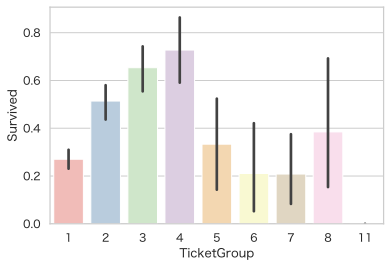

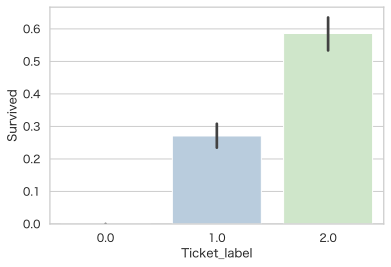

In [57]:
df = pd.read_pickle(DF_DIR/'all_family_comp.pkl')

# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Pastel1')
plt.show()

# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Pastel1')
plt.show()

df.to_pickle(DF_DIR/'all_ticket_comp.pkl')

## キャビン番号から特徴量を作成

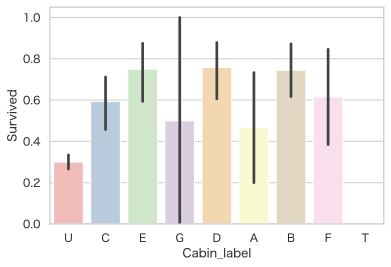

In [58]:
df = pd.read_pickle(DF_DIR/'all_ticket_comp.pkl')

# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Pastel1')
plt.show()

df.to_pickle(DF_DIR/'all_cabin_comp.pkl')

In [59]:
df = pd.read_pickle(DF_DIR/'all_cabin_comp.pkl')
df = df[['Survived','Pclass','Sex','Age','Fare', 'Embarked','Title','Family_label','Cabin_label','Ticket_label']]

# 欠損値をSで補完
# df['Embarked'] = df['Embarked'].fillna('S') 

display(df)

# # ラベル特徴量をワンホットエンコーディング
# df = pd.get_dummies(df)

# データセットを trainとtestに分割
df_train = df[df['Survived'].notnull()]
df_test = df[df['Survived'].isnull()].drop('Survived',axis=1)

df_train.to_pickle(DF_DIR/'train.pkl')
df_test.to_pickle(DF_DIR/'test.pkl')

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family_label,Cabin_label,Ticket_label
0,0.0,3,male,22.000000,7.2500,S,Mr,2.0,U,1.0
1,1.0,1,female,38.000000,71.2833,C,Mrs,2.0,C,2.0
2,1.0,3,female,26.000000,7.9250,S,Miss,1.0,U,1.0
3,1.0,1,female,35.000000,53.1000,S,Mrs,2.0,C,2.0
4,0.0,3,male,35.000000,8.0500,S,Mr,1.0,U,1.0
...,...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,28.488698,8.0500,S,Mr,1.0,U,1.0
1305,NaN,1,female,39.000000,108.9000,C,Royalty,1.0,C,2.0
1306,NaN,3,male,38.500000,7.2500,S,Mr,1.0,U,1.0
1307,NaN,3,male,28.488698,8.0500,S,Mr,1.0,U,1.0
